# Classify audio

In [1]:
from pathlib import Path

metadata_file = Path(r"D:\dataset\audio_mnist\audioMNIST_meta.txt")
dataset_path = Path(r"D:\dataset\audio_mnist\data")

In [2]:
import json
from IPython.display import display, JSON

with open(metadata_file, "r") as fd:
    metadata = json.loads(fd.read())
    display(JSON(metadata))

    nfolders = len(metadata.keys())

<IPython.core.display.JSON object>

In [3]:
SAMPLE_RATE = 16_000

#### Estimate audio length

### Convert audio to spectogram

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def load_audio(audio_path, target_sr=None):
    # Carga el audio
    y, sr = librosa.load(str(audio_path), sr=None)
    
    if target_sr is not None:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

    return y

def fix_length(audio, size):
    return librosa.util.fix_length(audio, size=size)

def calculate_spectogram(audio):
    # Calcula el espectrograma (magnitud en escala dB)
    S = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    return S_db
    

##### Load and view spectogram

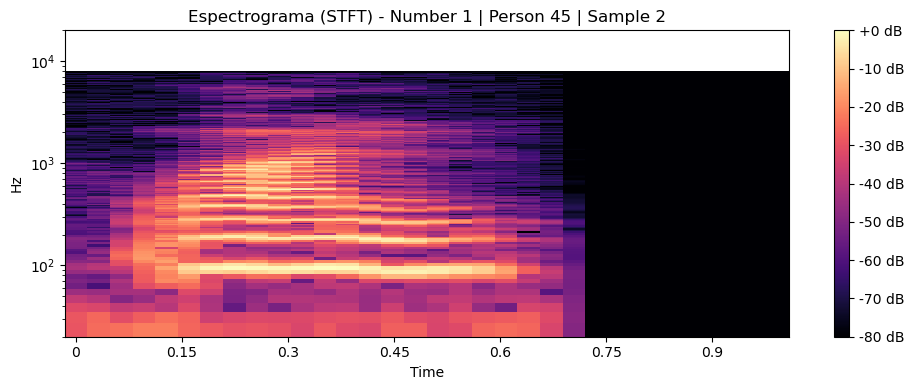

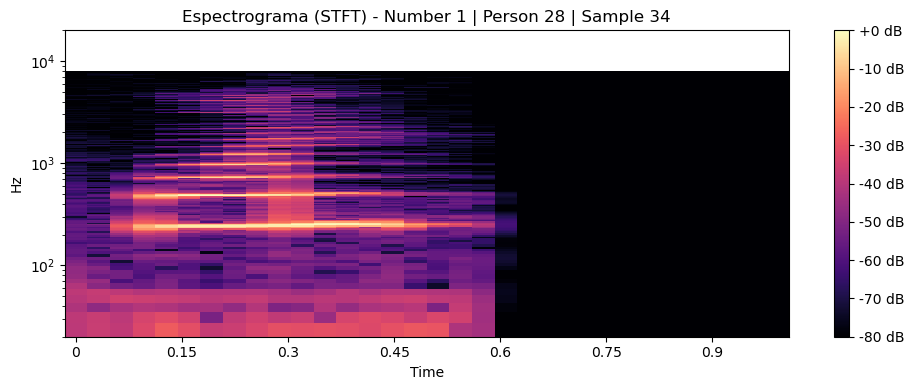

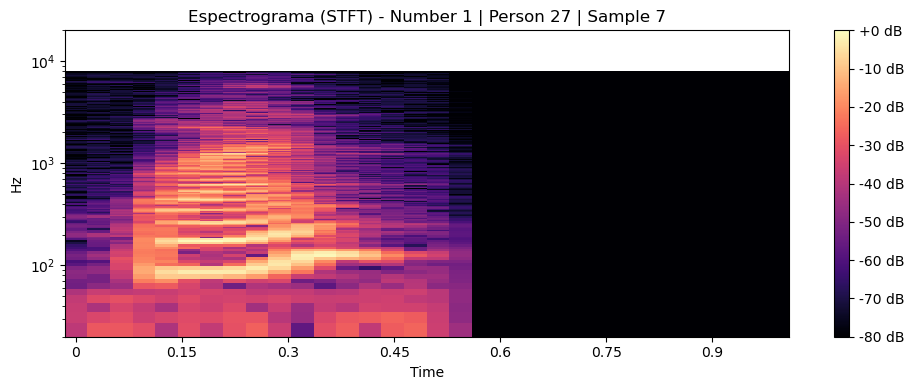

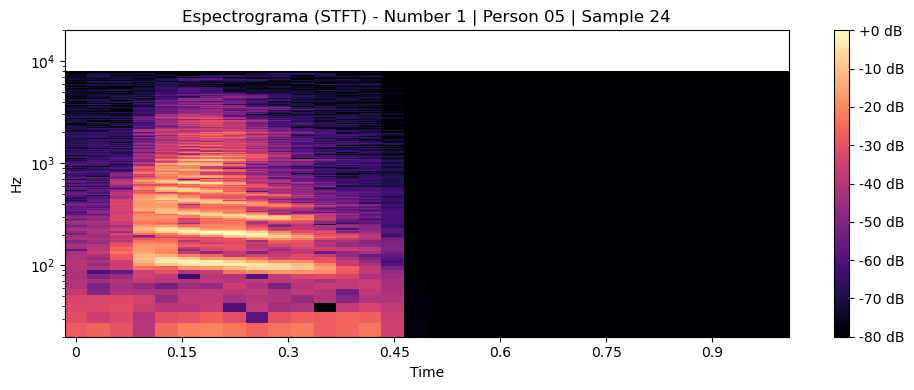

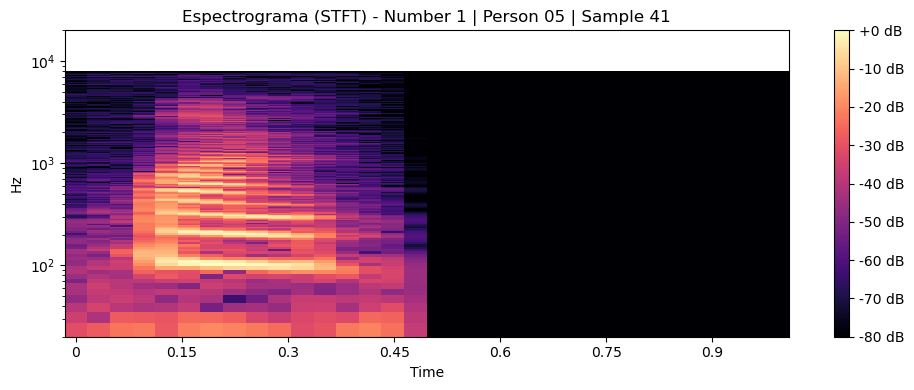

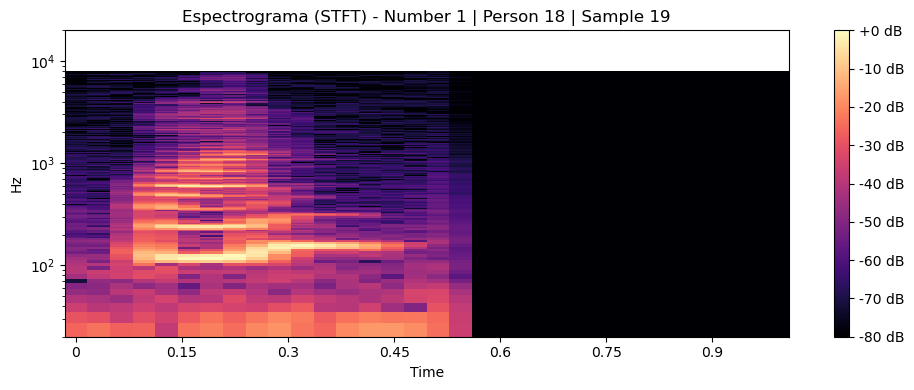

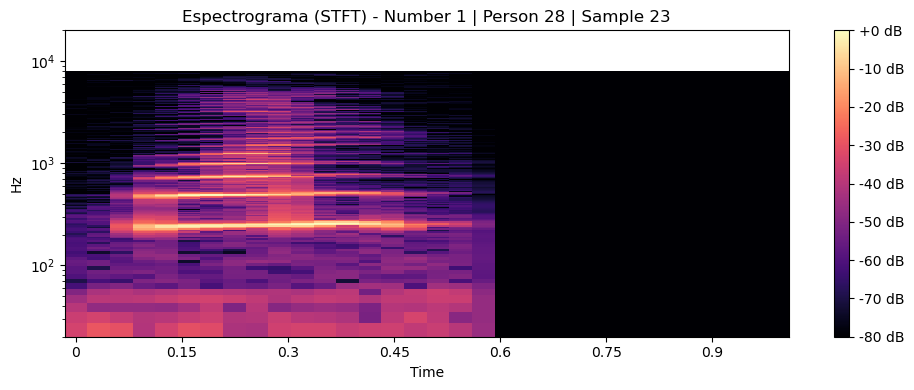

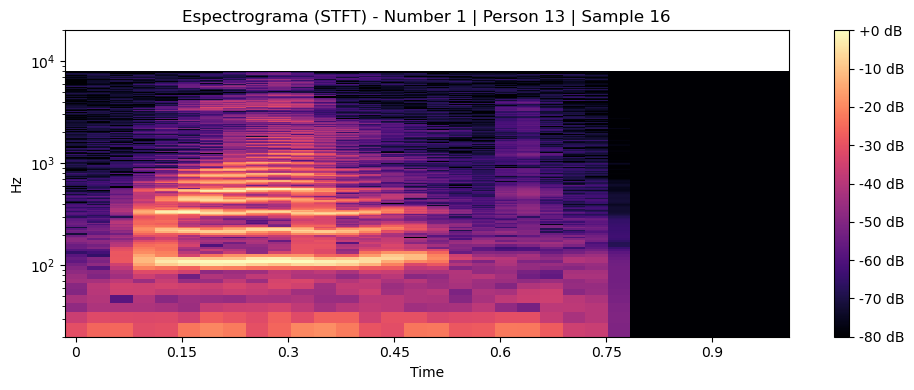

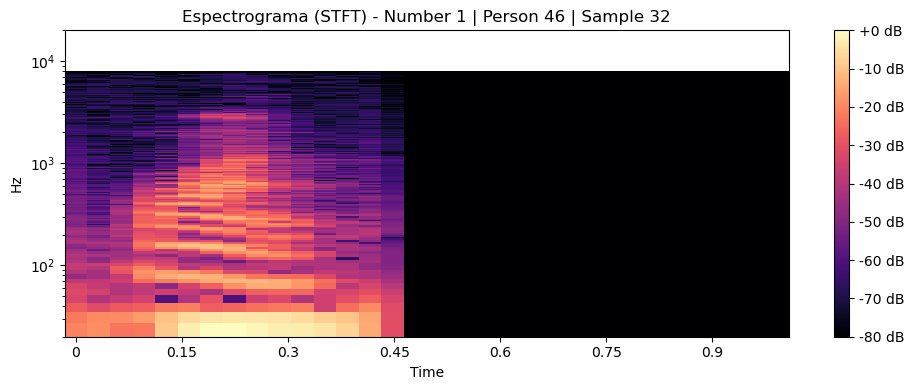

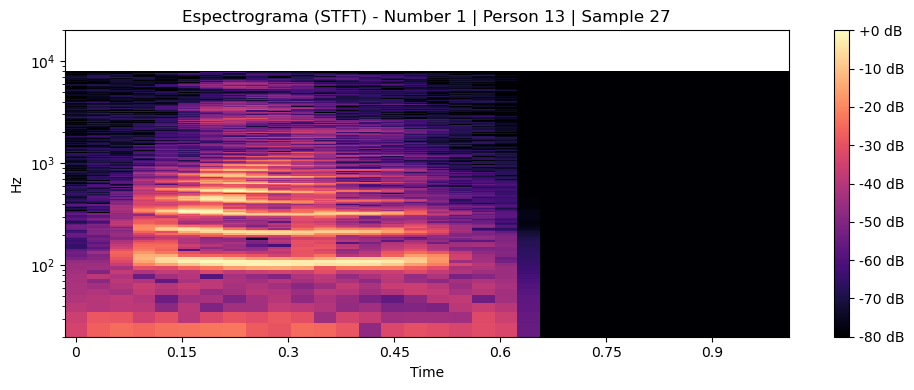

In [6]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

files = list(filter(lambda f : f.stem.startswith("1_"), dataset_path.rglob("*.wav")))

for fn in np.random.choice(files, 10):

    audio = load_audio(fn, target_sr=SAMPLE_RATE)
    audio = fix_length(audio, SAMPLE_RATE)
    S = calculate_spectogram(audio)
    
    display(Audio(fn))
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S, sr=SAMPLE_RATE, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format="%+2.0f dB")
    
    audio_name = fn.stem.split("_")
    plt.title(f"Espectrograma (STFT) - Number {audio_name[0]} | Person {audio_name[1]} | Sample {audio_name[2]}")
    plt.tight_layout()
    
    plt.yscale("log")
    plt.ylim(20, 20_000)  # limita a rango audible
    
    plt.show()

## Dataset

In [47]:
import torch
from torch.utils.data import Dataset
import pytorch_lightning as pl

SAMPLE_RATE = 16_000

class AudioMNISTDataset(Dataset):

    def __init__(self, datafolder, sample_rate=16_000, transform=None):
        self.__filepaths = list(datafolder.rglob("*.wav"))
        self.__sample_rate = sample_rate
    
    def __len__(self):
        return len(self.__filepaths)

    def __getitem__(self, idx):
        audio_path = self.__filepaths[idx]
        
        audio = load_audio(audio_path, target_sr=self.__sample_rate)
        audio = fix_length(audio, SAMPLE_RATE)
        S = calculate_spectogram(audio)

        label = int( audio_path.stem.split("_")[0] )
        
        S_tensor = torch.tensor(S, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)

        S_tensor = (S_tensor + 80) / 80

        S_tensor = S_tensor.unsqueeze(0)
        
        return S_tensor, label_tensor

In [48]:
audio_dataset = AudioMNISTDataset(dataset_path)

item = audio_dataset[0]
item

(tensor([[[0.2662, 0.6313, 0.6425,  ..., 0.0000, 0.0000, 0.0000],
          [0.5616, 0.6308, 0.6132,  ..., 0.0000, 0.0000, 0.0000],
          [0.6089, 0.5562, 0.5760,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),
 tensor(0))

torch.Size([1, 1025, 32]) torch.Size([])


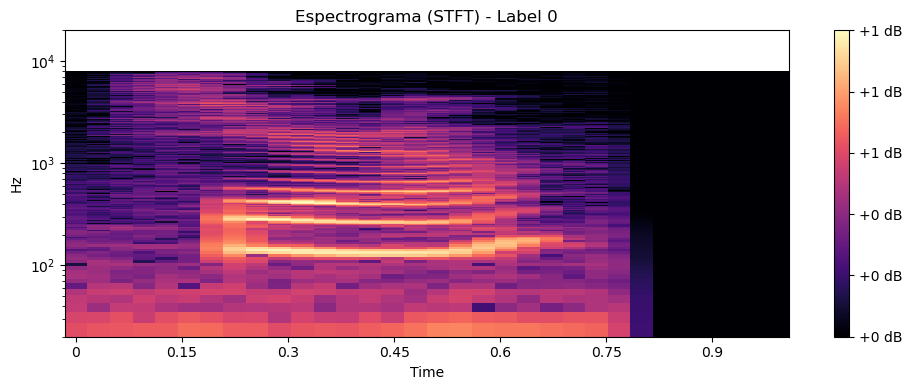

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Crear un array 2D de ejemplo
data = item[0].squeeze(0).numpy()

print(item[0].shape, item[1].shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(data, sr=SAMPLE_RATE, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format="%+2.0f dB")

plt.title(f"Espectrograma (STFT) - Label {item[1]}")
plt.tight_layout()

plt.yscale("log")
plt.ylim(20, 20_000)  # limita a rango audible

plt.show()

### Model

In [104]:
import pytorch_lightning as pl

class SpeechClassifier(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.__h1 = 10
        self.__h2 = 20

        self.__num_classes = 10
        
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=self.__h1, kernel_size=5, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(in_channels=self.__h1, out_channels=self.__h2, kernel_size=5, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Flatten(),
            
            torch.nn.Linear(in_features=20 * 254 * 6, out_features = 3800),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            
            torch.nn.Linear(in_features=3800, out_features = 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            
            torch.nn.Linear(in_features=1024, out_features = 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            
            torch.nn.Linear(in_features=256, out_features = self.__num_classes),
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log("test_loss", loss)
        self.log("test_acc", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
        

#### Data split

In [110]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split

class AudioMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, sample_rate=16000):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.sample_rate = sample_rate

    def setup(self, stage=None):
        full_dataset = AudioMNISTDataset(self.data_dir, sample_rate=self.sample_rate)

        train_len = int(0.7 * len(full_dataset))
        val_len = int(0.2 * len(full_dataset))
        test_len = len(full_dataset) - train_len - val_len

        generator = torch.Generator().manual_seed(42)
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_len, val_len, test_len], generator=generator
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)


#### Training

In [112]:
import pytorch_lightning as pl

audio_data_module = AudioMNISTDataModule(dataset_path, batch_size=32, sample_rate=16_000)

model = SpeechClassifier()

trainer = pl.Trainer(max_epochs=1)
trainer.fit(model, datamodule=audio_data_module)
trainer.test(model, datamodule=audio_data_module)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
D:\python\speech_recog\.cenv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float3

Sanity Checking: |                                                                               | 0/? [00:00<…

D:\python\speech_recog\.cenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\python\speech_recog\.cenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\python\speech_recog\.cenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9703333377838135
        test_loss           0.09128454327583313
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.09128454327583313, 'test_acc': 0.9703333377838135}]

---------------------------------